In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

(307511, 122)
(891, 12)


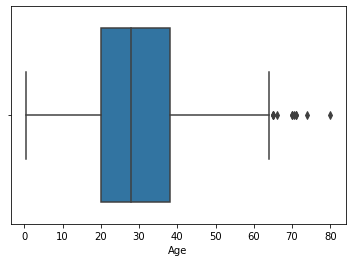

In [6]:
def load_application_train():
    data = pd.read_csv("application_train.csv")
    return data

df = load_application_train()
print(df.shape)        # (307511, 122)

def load():
    data = pd.read_csv("titanic.csv")
    return data



#See the shape of smaller dataset
df = load()
print(df.shape)       # (891, 12)




#Let's begin with the smaller dataset, "titanic.csv"
#We will try to detect outliers in a numerical 'Age' column by using 
#boxplot.

sns.boxplot(x=df["Age"])
plt.show()

In [7]:
q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr




#Now see outliers
print(df[(df["Age"] < low) | (df["Age"] > up)])

print(df[(df["Age"] < low) | (df["Age"] > up)].index)
print(df[(df["Age"] < low) | (df["Age"] > up)].any(axis=None))  #True
print(df[(df["Age"] < low)].any(axis=None))  #  False


     PassengerId  Survived  Pclass                                  Name  \
33            34         0       2                 Wheadon, Mr. Edward H   
54            55         0       1        Ostby, Mr. Engelhart Cornelius   
96            97         0       1             Goldschmidt, Mr. George B   
116          117         0       3                  Connors, Mr. Patrick   
280          281         0       3                      Duane, Mr. Frank   
456          457         0       1             Millet, Mr. Francis Davis   
493          494         0       1               Artagaveytia, Mr. Ramon   
630          631         1       1  Barkworth, Mr. Algernon Henry Wilson   
672          673         0       2           Mitchell, Mr. Henry Michael   
745          746         0       1          Crosby, Capt. Edward Gifford   
851          852         0       3                   Svensson, Mr. Johan   

      Sex   Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   male  66.0    

In [8]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit




print(outlier_thresholds(df, "Age"))

(-6.6875, 64.8125)


In [9]:
low, up = outlier_thresholds(df, "Fare")
print(df[(df["Fare"] < low) | (df["Fare"] > up)].head())

    PassengerId  Survived  Pclass  \
1             2         1       1   
27           28         0       1   
31           32         1       1   
34           35         0       1   
52           53         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
27                     Fortune, Mr. Charles Alexander    male  19.0      3   
31     Spencer, Mrs. William Augustus (Marie Eugenie)  female   NaN      1   
34                            Meyer, Mr. Edgar Joseph    male  28.0      1   
52           Harper, Mrs. Henry Sleeper (Myna Haxtun)  female  49.0      1   

    Parch    Ticket      Fare        Cabin Embarked  
1       0  PC 17599   71.2833          C85        C  
27      2     19950  263.0000  C23 C25 C27        S  
31      0  PC 17569  146.5208          B78        C  
34      0  PC 17604   82.1708          NaN        C  
52      0  PC 17572   76.7292         

In [10]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

print(check_outlier(df, "Age"))    # True  (yes, there is at least 1 outlier.)
print(check_outlier(df, "Fare"))

True
True


In [12]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car




cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "PassengerId"]
print(num_cols)  #  ['Age', 'Fare']



#We will check outliers in numerical columns.
for col in num_cols:
    print(col, check_outlier(df, col))

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
['Age', 'Fare']
Age True
Fare True


In [15]:
def grab_outliers(dataframe, col_name, outlier_index=False, f = 5):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head(f))
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if outlier_index:
        out_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return out_index
age_index = grab_outliers(df, "Age", True)
print(age_index)

     PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male   
96            97         0       1       Goldschmidt, Mr. George B  male   
116          117         0       3            Connors, Mr. Patrick  male   
280          281         0       3                Duane, Mr. Frank  male   

      Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   66.0      0      0  C.A. 24579  10.5000   NaN        S  
54   65.0      0      1      113509  61.9792   B30        C  
96   71.0      0      0    PC 17754  34.6542    A5        C  
116  70.5      0      0      370369   7.7500   NaN        Q  
280  65.0      0      0      336439   7.7500   NaN        Q  
Int64Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')


In [16]:
df = load()

low, up = outlier_thresholds(df, "Fare")

print(df.shape) # (891, 12)

print(df[~((df["Fare"] < low) | (df["Fare"] > up))].shape) #(775,12) 

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols.remove('PassengerId')

for col in num_cols:
    df = remove_outlier(df,col)

print(df.shape) # (765,12) 

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

#Import titanic data.
df = load()

cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols.remove('PassengerId')

#Let's see which column has outliers...
for col in num_cols:
    print(col, check_outlier(df, col))

#Now replace these outliers with thresholds.
for col in num_cols:
    replace_with_thresholds(df, col)

#After replacing, we shouldn't have any outlier. So let's check again.
for col in num_cols:
    print(col, check_outlier(df, col))


(891, 12)
(775, 12)
Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
(765, 12)
Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
Age True
Fare True
Age False
Fare False


(53940, 10)
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
(53940, 7)
   carat  depth  table  price     x     y     z
0   0.23   61.5   55.0    326  3.95  3.98  2.43
1   0.21   59.8   61.0    326  3.89  3.84  2.31
2   0.23   56.9   65.0    327  4.05  4.07  2.31
3   0.29   62.4   58.0    334  4.20  4.23  2.63
4   0.31   63.3   58.0    335  4.34  4.35  2.75
carat True
depth True
table True
price True
x True
y True
z True
(1889, 7)
(2545, 7)
[-1.58352526 -1.59732899 -1.62278873 ... -1.06721815 -1.00809552
 -1.00849038]
[-8.60430658 -8.20889984 -5.86084355 -4.98415175 -4.81502092]


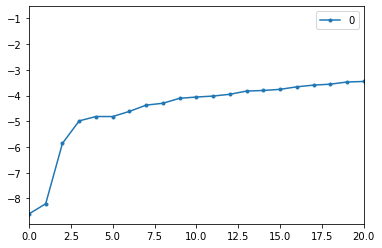

In [17]:
df = sns.load_dataset('diamonds')
print(df.shape)  #  (53940, 10)
print(df.head())

df = df.select_dtypes(include=['float64', 'int64'])
df = df.dropna()
print(df.shape)   #  (53940, 7)
print(df.head())

for col in df.columns:
    print(col, check_outlier(df, col))

low, up = outlier_thresholds(df, "carat")
print(df[((df["carat"] < low) | (df["carat"] > up))].shape)  # (1889, 7)

low, up = outlier_thresholds(df, "depth")
print(df[((df["depth"] < low) | (df["depth"] > up))].shape)  # (2545, 7)

clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_
print(df_scores)
print(np.sort(df_scores)[0:5]) # array([-8.60430658, -8.20889984, -5.86084355, -4.98415175, -4.81502092])

scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()

In [18]:
th = np.sort(df_scores)[3] # 4th point is our threshold.
print(th)                  # -4.9841





#Now let's look at the rows that are outliers.
print(df[df_scores < th])
'''
       carat  depth  table  price     x      y      z
41918   1.03   78.2   54.0   1262  5.72   5.59   4.42
48410   0.51   61.8   54.7   1970  5.12   5.15  31.80
49189   0.51   61.8   55.0   2075  5.15  31.80   5.12
'''





#And we drop these above 3 rows from our dataset...
print(df.drop(axis=0, labels=df[df_scores < th].index).shape)

-4.984151747711709
       carat  depth  table  price     x      y      z
41918   1.03   78.2   54.0   1262  5.72   5.59   4.42
48410   0.51   61.8   54.7   1970  5.12   5.15  31.80
49189   0.51   61.8   55.0   2075  5.15  31.80   5.12
(53937, 7)
